## Mini project from UBC MDS DSCI 573 Lab 4

This problem involves estimating whether a credit card client will default or not. We are using the [UCI default of credit card clients Data Set](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients). In this data set, there are 30,000 examples and 24 features, and the goal is to estimate whether a person will default (fail to pay) their credit card bills; this column is labeled "default payment next month" in the data. The rest of the columns can be used as features. 

In [516]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

import eli5 
import time
import shap

import altair as alt

alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [468]:
df = (pd.read_excel('credit_card_data.xls', header = 1)
      .drop(columns = "ID")
      .rename(columns = {'default payment next month': 'y'})
      .astype({'SEX': 'str', 'EDUCATION': 'str', 'MARRIAGE': 'str', 'PAY_0': 'str', 'PAY_2': 'str', 
                        'PAY_3': 'str', 'PAY_4': 'str', 'PAY_5': 'str', 'PAY_6': 'str'})
     )


X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = 'y'), df['y'], test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

In [118]:
print("Training set size: ", X_train.shape)
print("Validation set size: ", X_valid.shape)
print("Test set size: ", X_test.shape)

Training set size:  (19200, 23)
Validation set size:  (4800, 23)
Test set size:  (6000, 23)


### Simple EDA

In [262]:
y_train.value_counts()

0    14952
1     4248
Name: y, dtype: int64

- Class imbalance may become an issue.

In [113]:
X_train.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,19200.000000,19200.000000,19200.000000,19200.000000,19200.000000,19200.000000,19200.000000,19200.000000,19200.000000,19200.000000,...,1.920000e+04,19200.000000,19200.000000,19200.000000,19200.000000,1.920000e+04,19200.000000,19200.000000,19200.000000,19200.000000
mean,167457.691667,1.602135,1.855156,1.549844,35.550625,-0.014271,-0.128177,-0.163385,-0.216250,-0.261927,...,4.699577e+04,43149.014271,40493.799844,39072.000313,5699.287135,5.984147e+03,5254.087865,4990.404583,4816.734948,5164.597604
std,130197.609912,0.489470,0.793949,0.523339,9.279179,1.130297,1.201670,1.195562,1.173481,1.136035,...,7.008333e+04,64417.588663,61271.111994,59943.884693,17418.767288,2.563426e+04,18588.378266,17203.928291,15673.737384,17458.043696
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-1.572640e+05,-170000.000000,-81334.000000,-209051.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2.720000e+03,2341.750000,1786.000000,1312.000000,1000.000000,8.270000e+02,390.000000,296.000000,244.000000,104.750000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.996750e+04,19002.000000,18131.500000,17164.000000,2100.000000,2.005000e+03,1798.000000,1500.000000,1500.000000,1500.000000
75%,240000.000000,2.000000,2.000000,2.000000,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.962725e+04,54114.000000,50247.500000,49327.000000,5012.000000,5.000000e+03,4500.000000,4005.250000,4037.750000,4000.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,417990.000000,443001.000000


- There does not appear to be any major erroneous values except for education. The values of education should only be 1, 2, 3, or 4 according to the data set description. 

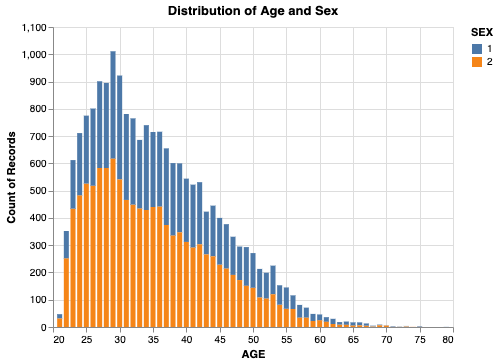

In [565]:
alt.Chart(X_train).mark_bar().encode(
    alt.X('AGE'),
    alt.Y('count()'),
    alt.Color('SEX:N')
).properties(title = "Distribution of Age and Sex")


- This is the distribution of people's age and sex in the dataset which could be useful information if we determine age and/or sex to be a key feature of the target. 

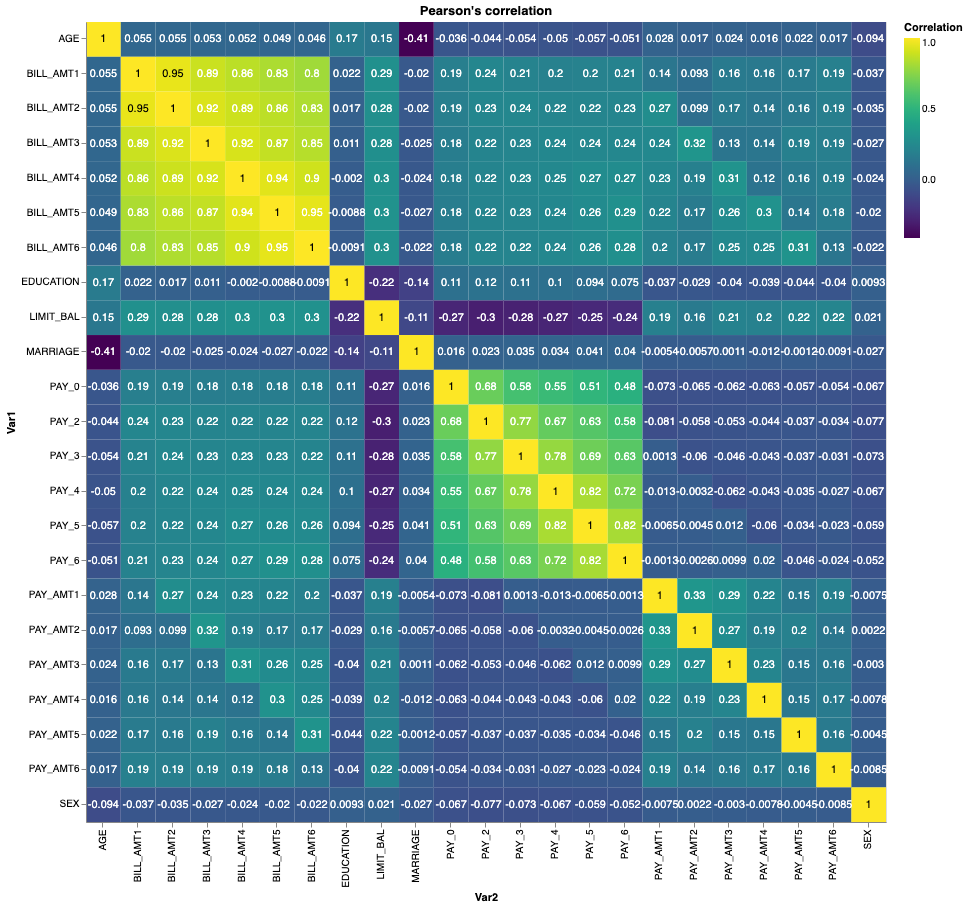

In [104]:
corr = X_train.corr().reset_index().rename(columns = {'index':'Var1'}).melt(id_vars = ['Var1'],
                                                                        value_name = 'Correlation',
                                                                        var_name = 'Var2')
base = alt.Chart(corr).encode(
    alt.Y('Var1:N'),
    alt.X('Var2:N')
) 

heatmap = base.mark_rect().encode(
     alt.Color('Correlation:Q',
                scale=alt.Scale(scheme='viridis'))
)

text = base.mark_text(baseline='middle').encode(
    text=alt.Text('Correlation:Q', format='.2'),
    color=alt.condition(
        alt.datum.Correlation >= 0.95,
        alt.value('black'),
        alt.value('white')
    )
)

(heatmap + text).properties(
    width = 800,
    height = 800,
    title = "Pearson's correlation"
)

- This may help us with identifying redundant features in our dataset.

### Baseline model

In [311]:
# This function was adapted from UBC MDS DSCI 573
def fit_and_report(model, X, y, Xv, yv, mode = 'classification'):
    """
    fits a model and returns train and validation errors
    
    Arguments
    ---------     
    model -- sklearn classifier model
        The sklearn model
    X -- numpy.ndarray        
        The X part of the train set
    y -- numpy.ndarray
        The y part of the train set
    Xv -- numpy.ndarray        
        The X part of the validation set
    yv -- numpy.ndarray
        The y part of the validation set       
    
    Keyword arguments 
    -----------------
    mode -- str 
        The mode for calculating error (default = 'regression') 
    
    Returns
    -------
    errors -- list
        A list containing train (on X, y) and validation (on Xv, yv) errors
    
    """
    model.fit(X, y)
    if mode.lower().startswith('regress'):
        errors = [mean_squared_error(y, model.predict(X)), mean_squared_error(yv, model.predict(Xv))]
    if mode.lower().startswith('classif'):
        errors = [1 - model.score(X,y), 1 - model.score(Xv,yv)]        
    print("Training error:   %.3f" % (1-model.score(X, y)))
    print("Validation error: %.3f" % (1-model.score(Xv, yv)))
    return errors
    

In [356]:
dummy = DummyClassifier()
dummy_errors = fit_and_report(dummy, X_train, y_train, X_valid, y_valid)

Training error:   0.342
Validation error: 0.344


### Logistic Regression

In [362]:
lr = LogisticRegression(solver = 'lbfgs', max_iter = 10000)

param_grid = {'C': 10**np.arange(-2, 2.1, 0.5)}


random_search = GridSearchCV(lr, 
                             param_grid = param_grid,
                             cv=5)

lr_errors = fit_and_report(random_search, X_train, y_train, X_valid, y_valid)

Training error:   0.221
Validation error: 0.224


In [363]:
train_scores = []
valid_scores = []

for C in param_grid['C']:
    lr = LogisticRegression(solver = 'lbfgs', C = C, max_iter = 10000)
    lr.fit(X_train, y_train)
    
    train_scores.append(1 - lr.score(X_train, y_train))
    valid_scores.append(1 - lr.score(X_valid, y_valid))
    

In [364]:
plot_df = pd.DataFrame({"Hyperparameter C": param_grid['C'],
                     "Train": train_scores,
                     "Validation": valid_scores})

plot_df = pd.melt(plot_df, 
        id_vars=['Hyperparameter C'], 
        value_vars=['Train', 'Validation'],
        var_name='Set', 
        value_name='Error')

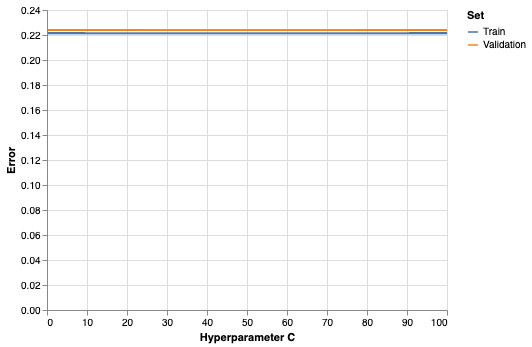

In [365]:
alt.Chart(plot_df).mark_line().encode(
    alt.X("Hyperparameter C:Q"),
    alt.Y("Error:Q"),
    alt.Color("Set")
)

- It seems like our model gets the same results with every value of C. I highly doubt our data is linearly separable which would not be suitable for logistic regression. 

In [448]:
lr_1 = LogisticRegression(solver = 'lbfgs', C = 0.1, max_iter = 10000)
lr_1.fit(X_train, y_train)
train_preds = lr_1.predict(X_train) 
print("Train confusion matrix for C = 0.1:")
pd.DataFrame(confusion_matrix(y_train, train_preds), 
             columns=['Predicted (No)', 'Predicted (Yes)'],
             index=['Actual (No)', 'Actual (Yes)'])

Train confusion matrix for C = 0.1:


,Predicted (No),Predicted (Yes)
Actual (No),14950,2
Actual (Yes),4248,0


In [450]:
lr_2 = LogisticRegression(solver = 'lbfgs', C = 10, max_iter = 10000)
lr_2.fit(X_train, y_train)
train_preds = lr_2.predict(X_train) 
print("Train confusion matrix for C = 10:")
pd.DataFrame(confusion_matrix(y_train, train_preds), 
             columns=['Predicted (No)', 'Predicted (Yes)'],
             index=['Actual (No)', 'Actual (Yes)'])

Train confusion matrix for C = 10:


,Predicted (No),Predicted (Yes)
Actual (No),14950,2
Actual (Yes),4248,0


- It seems like our model is only predicting 1 class which means the threshold is not set optimally. 

### Feature transformations

In [469]:
numeric_features = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 
                    'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 
                    'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'PAY_0', 
                    'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE']


preprocessor = ColumnTransformer(transformers=[
        ('scale', StandardScaler(), numeric_features),
        ('ohe', OneHotEncoder(categories = 'auto', sparse = False), categorical_features)])

lr = LogisticRegression(solver = 'lbfgs', max_iter = 1000)

param_grid = {'classifier__C': 10**np.arange(-2, 2.1, 0.5)}

lr_clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', lr)])

random_search = GridSearchCV(lr_clf, 
                             param_grid = param_grid,
                             cv=5)

lr_ft_errors = fit_and_report(random_search, X_train, y_train, X_valid, y_valid)

Training error:   0.189
Validation error: 0.190


- This improved the errors by approximately 3% in both the training and validation sets.

### Different classifiers

In [322]:
classifiers = {
    'SVM': SVC(gamma="scale"),
    'xgboost': XGBClassifier(),
    'sklearn NN': MLPClassifier() 
}

train_scores = dict()
validation_scores = dict()
training_times = dict()

for classifier_name, classifier_obj in classifiers.items():
    print("Fitting", classifier_name)
    t = time.time()
    clf_obj = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', classifier_obj)])
    train_error, valid_error = fit_and_report(clf_obj, X_train, y_train, X_valid, y_valid)
    
    training_times[classifier_name] = time.time() - t
    train_scores[classifier_name] = train_error
    validation_scores[classifier_name] = valid_error

Fitting SVM
Training error:   0.172
Validation error: 0.188
Fitting xgboost
Training error:   0.172
Validation error: 0.184
Fitting sklearn NN
Training error:   0.163
Validation error: 0.189


In [326]:
data = {"train error": train_scores, 
        "validation error" : validation_scores, 
        "training time (s)" : training_times}
df = pd.DataFrame(data, columns=data.keys())
df.index = list(classifiers.keys())
df

,train error,validation error,training time (s)
SVM,0.172500,0.187500,36.567086
xgboost,0.172500,0.184167,4.916509
sklearn NN,0.162604,0.188542,14.651946


- All of the models seems to do marginally better (~0.3-0.6%) on the validation sets. On the training set we do slightly better (~2-3%). We might be overfitting the training set here but it is not severe.

### Hyperparameter optimization

In [374]:
classifiers = {
    'SVM': SVC(gamma="scale"),
    'xgboost': XGBClassifier(),
    'sklearn NN': MLPClassifier() 
}

param_grid = {
    'SVM': {'classifier__C': 10**np.arange(-2, 2.1, 0.8)},
    'xgboost': {'classifier__learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
                'classifier__n_estimators': np.arange(50, 200, 30)},
    'sklearn NN': {'classifier__activation': ['tanh', 'relu'], 
                   'classifier__solver': ['sgd', 'adam']}
}


train_scores = dict()
validation_scores = dict()
training_times = dict()
best_parameters = dict()

for classifier_name, classifier_obj in classifiers.items():
    print("Fitting", classifier_name)
    t = time.time()
    clf_obj = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', classifier_obj)])
    
    
    random_search = RandomizedSearchCV(clf_obj, 
                             param_distributions = param_grid[classifier_name],
                             cv=5)
    train_error, valid_error = fit_and_report(random_search, X_train, y_train, X_valid, y_valid)
    
    training_times[classifier_name] = time.time() - t
    train_scores[classifier_name] = train_error
    validation_scores[classifier_name] = valid_error
    best_parameters[classifier_name] = random_search.best_params_


Fitting SVM


/Users/bradentam/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Training error:   0.167
Validation error: 0.187
Fitting xgboost
Training error:   0.173
Validation error: 0.185
Fitting sklearn NN


/Users/bradentam/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/Users/bradentam/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/bradentam/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/bradentam/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached a

Training error:   0.178
Validation error: 0.186


In [382]:
data_tuned = {"train error": train_scores, 
              "validation error" : validation_scores, 
              "training time (s)" : training_times,
              "best parameters": best_parameters}
df = pd.DataFrame(data_tuned, columns=data_tuned.keys())
df.index = list(classifiers.keys())
pd.set_option('display.max_colwidth', -1)
df


,train error,validation error,training time (s),best parameters
SVM,0.167448,0.187292,752.787372,{'classifier__C': 2.5118864315095824}
xgboost,0.173177,0.184583,228.446619,"{'classifier__n_estimators': 80, 'classifier__learning_rate': 0.1}"
sklearn NN,0.177604,0.185833,268.089797,"{'classifier__solver': 'sgd', 'classifier__activation': 'relu'}"


### Feature selection

In [395]:
lr_l1 = LogisticRegression(solver = 'liblinear', max_iter = 1000, penalty = 'l1')
feature_sel = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', lr_l1)])

errors = fit_and_report(feature_sel, X_train, y_train, X_valid, y_valid)
print("number of non-zero coefficients:", feature_sel['classifier'].coef_.shape[1] - np.count_nonzero(feature_sel['classifier'].coef_))

Training error:   0.189
Validation error: 0.190
number of non-zero coefficients: 3


In [444]:
column_names = numeric_features + list(preprocessor.named_transformers_['ohe'].get_feature_names(categorical_features))
pd.DataFrame(column_names, list(lr_l1.coef_[0] != 0))


,0
True,LIMIT_BAL
True,AGE
True,BILL_AMT1
True,BILL_AMT2
True,BILL_AMT3
True,BILL_AMT4
True,BILL_AMT5
True,BILL_AMT6
True,PAY_AMT1
True,PAY_AMT2


- It appears that there is redundancy within sex, education, and marriage. 

In [478]:
X_train_pp = pd.DataFrame(preprocessor.fit_transform(X_train),
                       index=X_train.index,
                       columns=(numeric_features +
                                list(preprocessor.named_transformers_['ohe']
                                     .get_feature_names(categorical_features))))

X_valid_pp = pd.DataFrame(preprocessor.transform(X_valid),
                       index=X_valid.index,
                       columns=X_train_pp.columns)


X_test_pp = pd.DataFrame(preprocessor.transform(X_test),
                      index=X_test.index,
                      columns=X_train_pp.columns)


In [497]:
selected_feats = list(np.where(lr_l1.coef_[0] != 0)[0])

X_train_pp_fs = X_train_pp.iloc[:, selected_feats]
X_valid_pp_fs = X_valid_pp.iloc[:, selected_feats]
X_test_pp_fs = X_test_pp.iloc[:, selected_feats]


In [501]:
lr = LogisticRegression(solver = 'lbfgs', max_iter = 10000)

param_grid = {'C': 10**np.arange(-2, 2.1, 0.5)}

random_search = GridSearchCV(lr, 
                             param_grid = param_grid,
                             cv=5)

lr_ft_errors = fit_and_report(random_search, X_train_pp_fs, y_train, X_valid_pp_fs, y_valid)

Training error:   0.189
Validation error: 0.190


- Feature selection does not change the errors of the logistic regression model. This may be due to the fact that we hadn't penalized for complexity in the previous model or that we are only removing 3 out of the 33 features which is not a significant amount. 
- We will use the model with reduced features as it is slightly simpler and achieves the same results.

### Interpretation and feature importance 

In [552]:
xgb = XGBClassifier(n_estimators=80, learning_rate=0.1)

xgb_errors = fit_and_report(xgb, X_train_pp_fs, y_train, X_valid_pp_fs, y_valid)

Training error:   0.173
Validation error: 0.184


In [520]:
features = list(X_train_pp_fs.columns)
eli5.show_weights(xgb, feature_names = features)
eli5.explain_weights(xgb, feature_names = features)

Weight,Feature
0.3779,PAY_0
0.1349,PAY_2
0.0636,PAY_3
0.0402,PAY_4
0.0359,PAY_6
0.0355,PAY_AMT3
0.0303,PAY_AMT1
0.0289,PAY_AMT4
0.0245,LIMIT_BAL
0.0225,PAY_AMT2


- The weights of the features give us the proportion of contribution in the model toward predicting the target. The most important feature in predicting the target is `PAY_0`.

In [522]:
shap.initjs()
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train_pp_fs)

In [543]:
shap.force_plot(explainer.expected_value, 
                shap_values[:1000,:], 
                X_train_pp_fs.iloc[:1000,:])

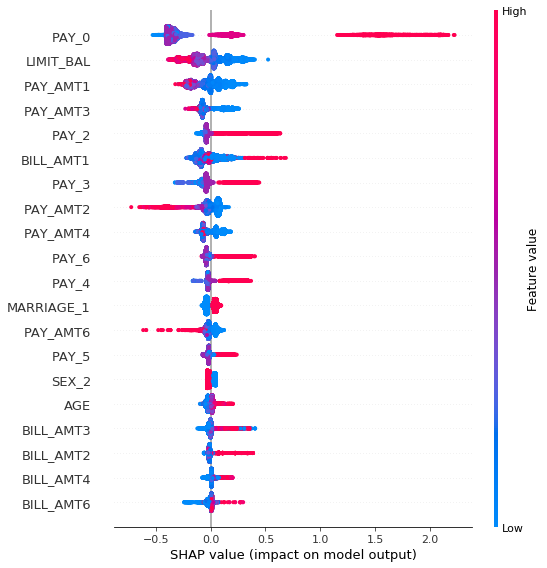

In [531]:
shap.summary_plot(shap_values, X_train_pp_fs)

- This visualization is consistent with the previous one as `PAY_0` has large values to the right of the plot, indicating it is the most important feature.

### Results on the test set

In [560]:
X_train_valid = pd.concat([X_train_pp_fs, X_valid_pp_fs])
y_train_valid = pd.concat([y_train, y_valid])
xgb.fit(X_train_valid, y_train_valid)
print('Training error: ', 1 - xgb.score(X_train_valid, y_train_valid))
print('Test error: ', 1 - xgb.score(X_test_pp_fs, y_test))

Training error:  0.17500000000000004
Test error:  0.1791666666666667


- The test error does slightly better than the validation error which is expected if we've done our whole analysis properly.

- I think these results are fairly robust given the confusion matrices. There are definitely a high proportion of false positives, which with further tweaking can be improved. I don't think there optimization bias is an issue here as we aren't intensively trying to optimize the validation error. 

In [566]:
print('Test error: ', 1 - xgb.score(X_test_pp_fs, y_test))

Test error:  0.1791666666666667


In [567]:
train_preds = xgb.predict(X_train_valid) 
print("Train confusion matrix:")
pd.DataFrame(confusion_matrix(y_train_valid, train_preds), 
             columns=['Predicted (No)', 'Predicted (Yes)'],
             index=['Actual (No)', 'Actual (Yes)'])

Train confusion matrix:


,Predicted (No),Predicted (Yes)
Actual (No),17821,856
Actual (Yes),3344,1979


In [568]:
test_preds = xgb.predict(X_test_pp_fs) 
print("Test confusion matrix:")
pd.DataFrame(confusion_matrix(y_test, test_preds), 
             columns=['Predicted (No)', 'Predicted (Yes)'],
             index=['Actual (No)', 'Actual (Yes)'])

Test confusion matrix:


,Predicted (No),Predicted (Yes)
Actual (No),4463,224
Actual (Yes),851,462
